In [15]:
import pandas as pd
import numpy as np
from pathlib import Path

def load_data(path : str | Path = r"C:\Users\DELL\OneDrive\Desktop\anu course\datasets\Supply_chain.csv"):
    path = Path(path)

    df=pd.read_csv(path)
    x=df.drop(columns="TotalRevenue",axis=1)
    y=df["TotalRevenue"]

    return x,y

In [17]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler,OneHotEncoder

def build_preprocessor(x):
    num_cols = x.select_dtypes(include=["int64","float64"]).columns
    cat_cols = x.select_dtypes(include=["object"]).columns

    num_transformer = StandardScaler()
    cat_transformer = OneHotEncoder(handle_unknown="ignore")

    preprocessor = ColumnTransformer(transformers=[("num",num_transformer,num_cols),("cat",cat_transformer,cat_cols)])

    return preprocessor , num_cols ,cat_cols

In [39]:
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor

def build_regression_pipeline(preprocessor):
    model = XGBRegressor(n_estimators=100,max_depth=6,random_state=42)

    pipeline = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("xgb", model)
    ])
    return pipeline

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_feature_importances(model, feature_names, top_n=20):
    # Extract feature importances
    importances = model.named_steps['xgb'].feature_importances_
    
    # Match with feature names from preprocessing
    features = pd.Series(importances, index=feature_names)
    
    # Sort and select top_n
    top_features = features.sort_values(ascending=False).head(top_n)
    
    # Plot
    plt.figure(figsize=(10,6))
    sns.barplot(x=top_features.values, y=top_features.index, palette="viridis")
    plt.title("Top Feature Importances (XGB)")
    plt.xlabel("Importance Score")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()


In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

def plot_model_results(y_test, y_pred):
    
    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.7)
    plt.plot([y_test.min(), y_test.max()],
             [y_test.min(), y_test.max()],
             'r--', lw=2)  
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title("Actual vs Predicted")

    
    plt.subplot(1,2,2)
    residuals = y_test - y_pred
    sns.scatterplot(x=y_pred, y=residuals, alpha=0.7)
    plt.axhline(y=0, color='r', linestyle='--', lw=2)
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals (Actual - Predicted)")
    plt.title("Residuals vs Predicted")

    plt.tight_layout()
    plt.show()

In [45]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score,mean_absolute_error,root_mean_squared_error,classification_report

import pandas as pd

def remove_outliers_iqr(df, cols):
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

def main(mode=XGBRegressor):
    x,y=load_data()

    num_cols = x.select_dtypes(include=["int64","float64"]).columns
    x = remove_outliers_iqr(x, num_cols)
    y = y.loc[x.index]
    
    preprocessor,num_cols,cat_cols = build_preprocessor(x)
    x_train,x_test,y_train,y_test = train_test_split(x,y,random_state=42,test_size=0.33)

    model = build_regression_pipeline(preprocessor)
    model.fit(x_train,y_train)
    y_pred = model.predict(x_test)

    plot_model_results(y_test, y_pred)

    # Get feature names from preprocessor
    feature_names = (
        model.named_steps['preprocessor']
        .get_feature_names_out()
    )
    
    # Plot top features
    plot_feature_importances(model, feature_names, top_n=15)

    
    print("MAE : " , (mean_absolute_error(y_test,y_pred)))
    print("RMSE : " , (root_mean_squared_error(y_test,y_pred)))
    print("R2 : " , (r2_score(y_test,y_pred)))

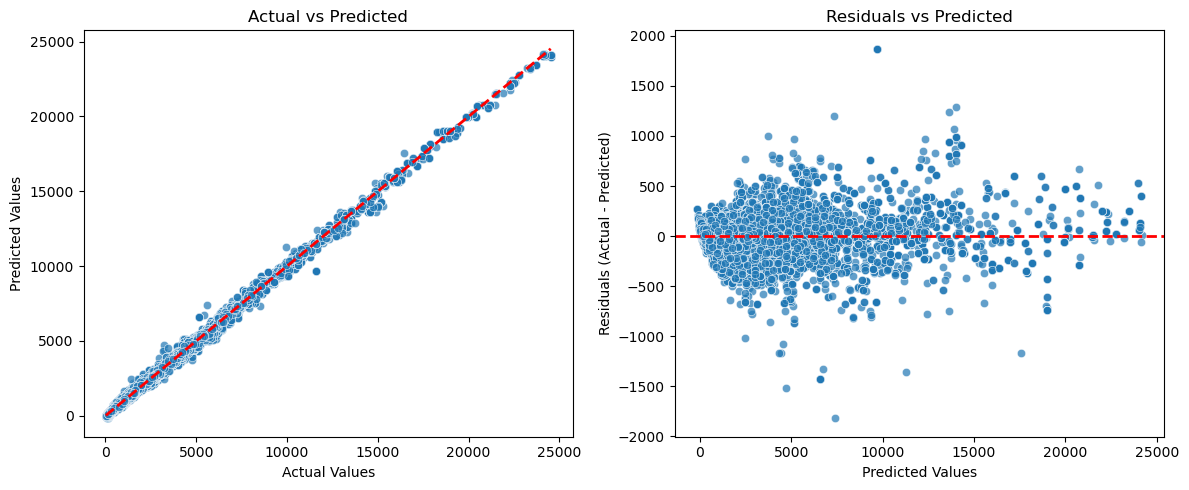

C:\Users\DELL\AppData\Local\Temp\ipykernel_22568\2507503503.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features.values, y=top_features.index, palette="viridis")


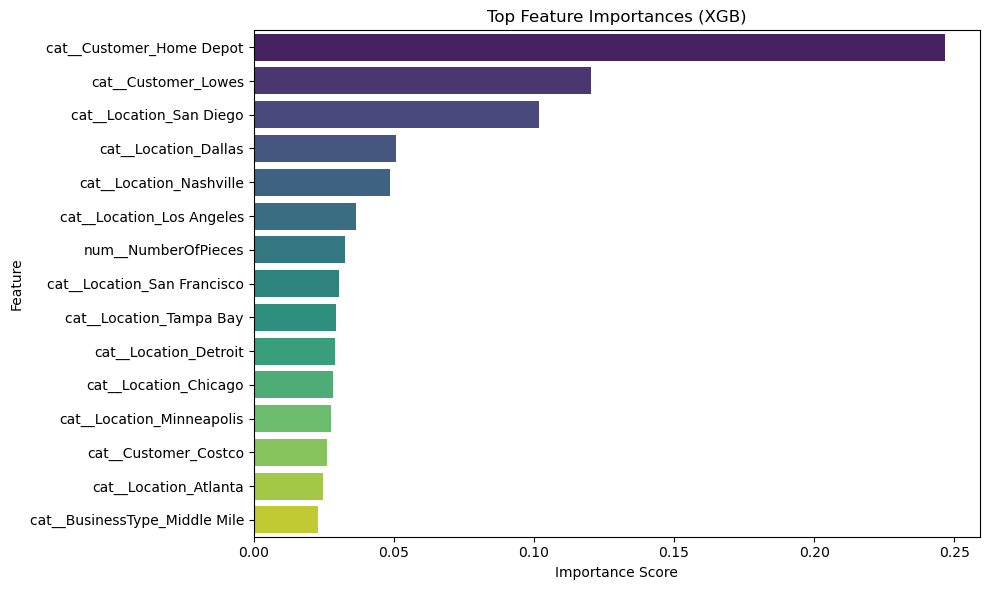

MAE :  76.4950895909956
RMSE :  123.21760058617218
R2 :  0.9978836020996907


In [47]:
if __name__ == '__main__':
    main(mode=XGBRegressor)